In [1]:
import pymysql
import numpy as np
import datetime
import matplotlib as mpl
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


#원 핫 인코딩 하는 함수
def dummy_data(data, columns): 
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

Using TensorFlow backend.


In [2]:
# 모델 불러오기
from keras.models import load_model

model = load_model('new1_2_1200_500.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [3]:
#db에서 데이터 가져오기 - 원핫인코딩 테스트

conn = pymysql.connect(host="leejs-dbins.cuqks267yd6q.ap-northeast-2.rds.amazonaws.com", user="DA_SeoulBike", password="engineering403", db="teamdata", charset="utf8mb4")
cursor = conn.cursor()
sql="SELECT td.대여횟수,td.대여소,td.년,td.월,td.일, td.시간, td.기온, td.강수여부,td.PM10매우나쁨,td.PM10나쁨, td.PM10보통, td.PM10좋음, td.PM25매우나쁨, td.PM25나쁨, td.PM25보통, td.PM25좋음, td.월요일, td.화요일, td.수요일, td.목요일, td.금요일, td.토요일, td.일요일, td.공휴일, td.구  FROM teamdata.Total_Dataset td inner join (SELECT 대여소, sum(대여횟수) as num FROM teamdata.Rent_by_hour group by 대여소 order by num desc limit 265) a on td.대여소=a.대여소 where td.대여일시 >='2018-09-01';"
cursor.execute(sql)
db=cursor.fetchall()

In [4]:
dataset=[]

for n in range (0,len(db)):
    tempdata=[db[n][0],db[n][1],db[n][2],db[n][3],db[n][4],db[n][5],db[n][6],db[n][7],db[n][8],db[n][9],db[n][10],db[n][11],db[n][12],db[n][13],db[n][14],db[n][15],db[n][16],db[n][17],db[n][18],db[n][19],db[n][20],db[n][21],db[n][22],db[n][23],db[n][24]]
    dataset.append(tempdata)

In [5]:
label=['대여횟수','대여소','년','월','일', '시간', '기온', '강수여부','PM10매우나쁨','PM10나쁨', 'PM10보통', 'PM10좋음', 'PM25매우나쁨', 'PM25나쁨', 'PM25보통', 'PM25좋음', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', '공휴일','구']

df=pd.DataFrame.from_records(dataset, columns=label) 

In [6]:
dummy_columns=['대여소','구']

train_values=dummy_data(df, dummy_columns)

In [8]:
#대이터 구조 변경
test_values=np.array(train_values)

In [9]:
# integer encode direction
encoder = LabelEncoder()
test_values[:,311] = encoder.fit_transform(test_values[:,311])

In [10]:
# ensure all data is float
test_values = test_values.astype('float32')

In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.fit_transform(test_values)

In [12]:
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, 1, 1)

In [13]:
# drop columns we don't want to predict
reframed_test.drop(reframed_test.columns[[313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623]], axis=1, inplace=True)

In [14]:
#모델용 트레인,테스트 / 검증용 테스트 만들기
test_values = reframed_test.values
# split into input and outputs
test_values_X, test_values_y = test_values[:, :-1], test_values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_values_X=test_values_X.reshape((test_values_X.shape[0], 1, test_values_X.shape[1]))

In [15]:
# make a prediction
yhat = model.predict(test_values_X)
test_X = test_values_X.reshape((test_values_X.shape[0], test_values_X.shape[2]))

In [16]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_values_y = test_values_y.reshape((len(test_values_y), 1))
inv_y = concatenate((test_values_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.738


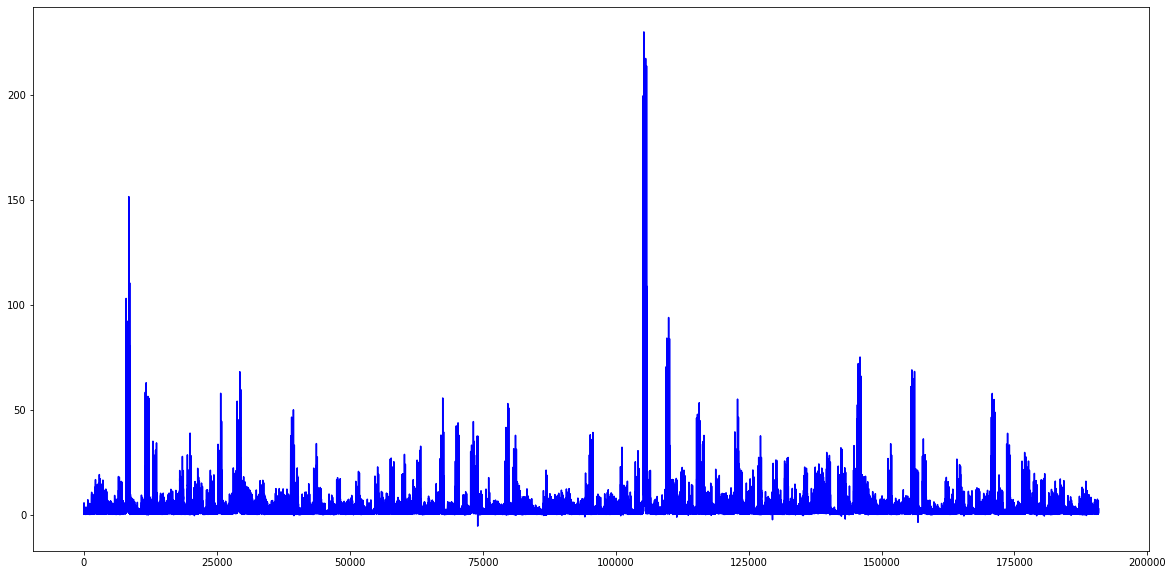

In [18]:
pyplot.figure(figsize=(20,10))
pyplot.plot(inv_yhat,'b', label='yhat')
pyplot.show()

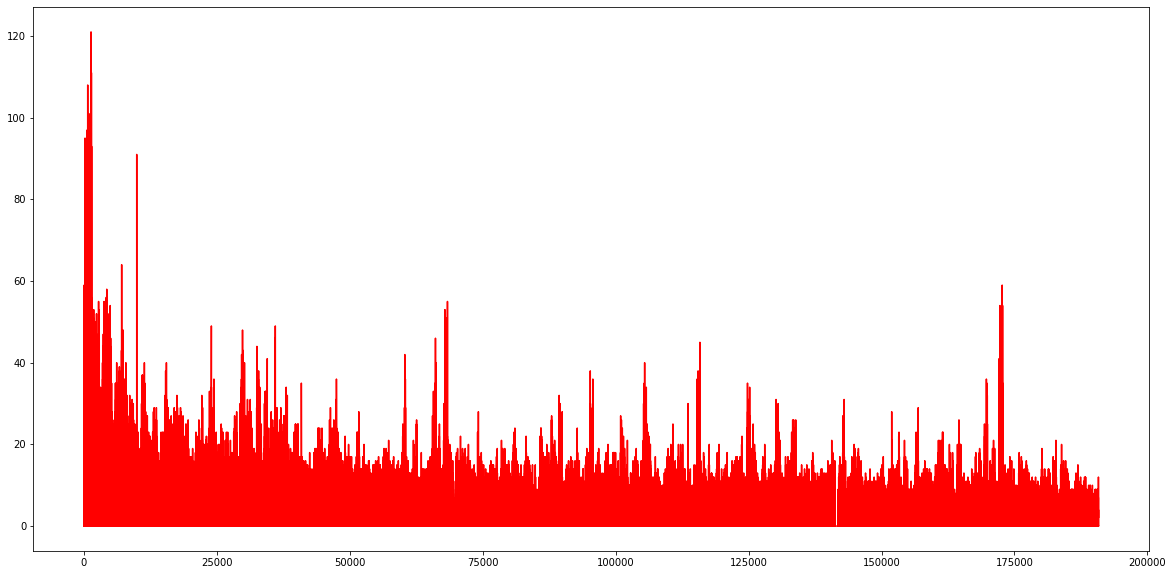

In [19]:
pyplot.figure(figsize=(20,10))
pyplot.plot(inv_y,'r', label='test')
pyplot.show()

F:\AnaConda\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


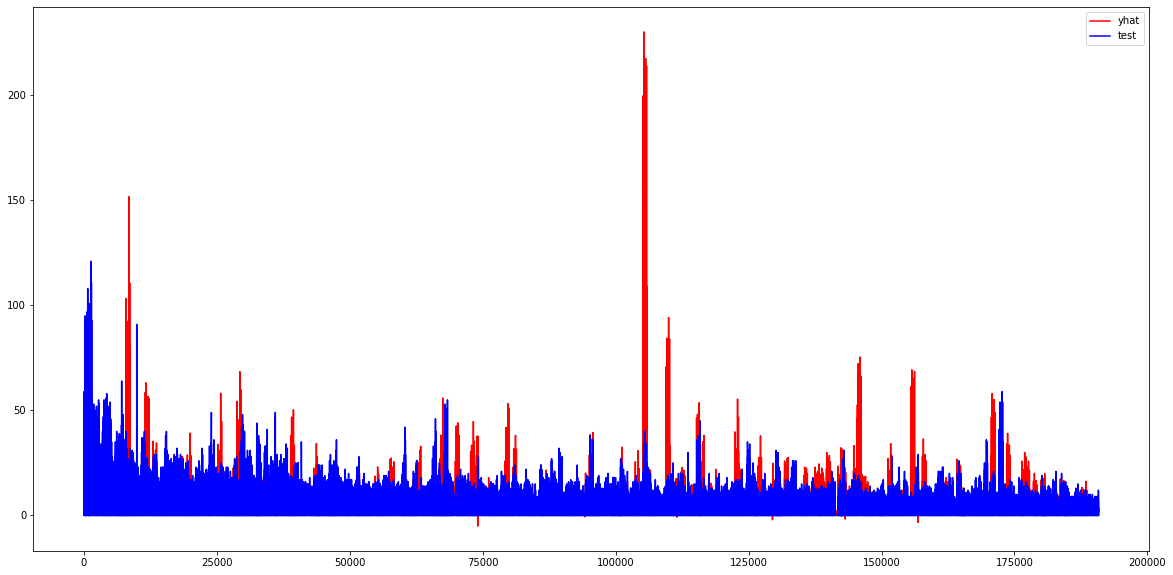

In [20]:
pyplot.figure(figsize=(20,10))
pyplot.plot(inv_yhat,'r', label='yhat')
pyplot.plot(inv_y,'b', label='test')
pyplot.legend()
pyplot.show()

In [23]:
inv_y

array([ 23.      ,   8.      ,   1.      ,   6.      ,   0.      ,
         3.      ,   4.      ,   4.      ,   4.      ,   9.      ,
         4.      ,   6.      ,  12.      ,  20.      ,  23.      ,
        56.      ,  48.      ,  53.      ,  52.      ,  22.      ,
        22.      ,  40.      ,  30.000002,  18.      ,   8.      ,
        12.      ,   7.      ,   0.      ,   5.      ,   3.      ,
         1.      ,   2.      ,   3.      ,  13.      ,  10.      ,
         7.      ,  14.      ,  16.      ,  39.      ,  56.      ,
        39.      ,  51.      ,  59.      ,  44.      ,  42.      ,
        36.      ,  30.000002,  16.      ,   4.      ,   9.      ,
         1.      ,   1.      ,   1.      ,   2.      ,  10.      ,
        13.      ,   4.      ,   1.      ,   3.      ,   1.      ,
         2.      ,   3.      ,   0.      ,   0.      ,   1.      ,
         0.      ,   0.      ,   3.      ,   1.      ,   0.      ,
         3.      ,   2.      ,   0.      ,   0.      ,   0.   